In [41]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [42]:
#random seed for reproducibility
torch.manual_seed(42)

In [43]:
#check for gpu availablity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [44]:
df= pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


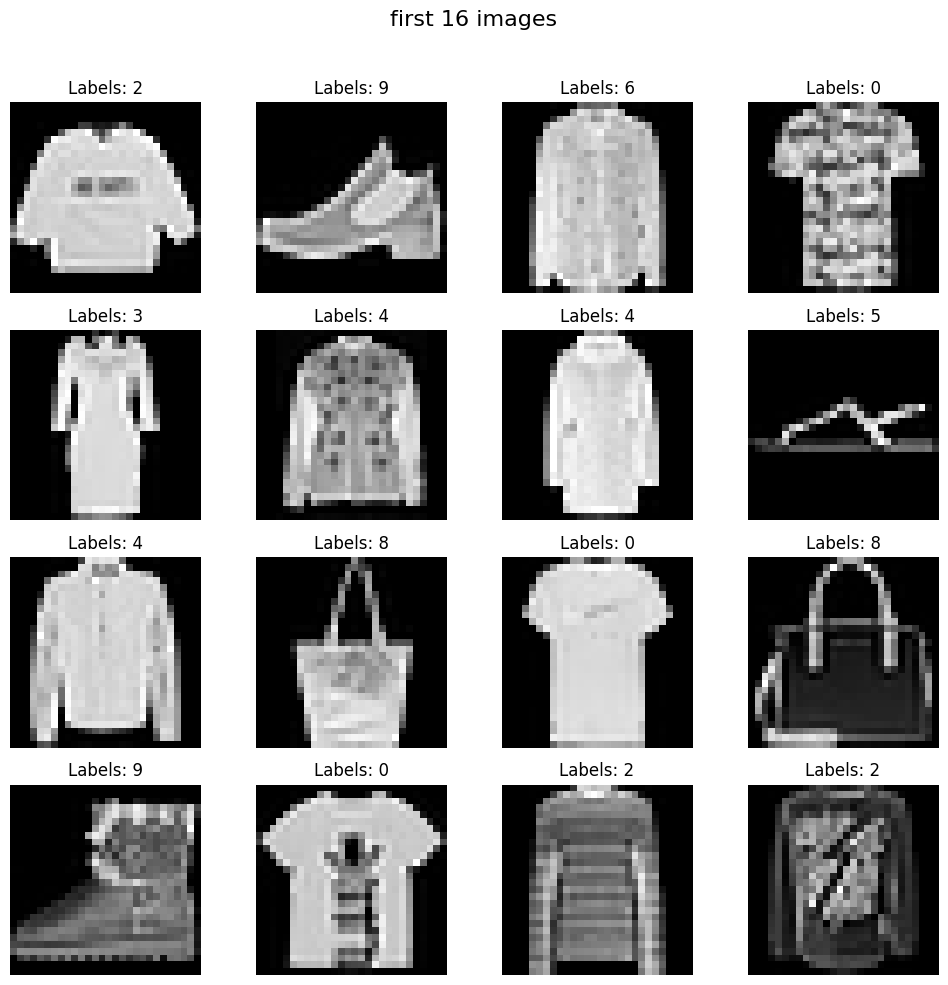

In [45]:
#create 4*4 grid of images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
fig.suptitle("first 16 images", fontsize=16)

#plot first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    ax.imshow(df.iloc[i,1:].values.reshape(28,28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Labels: {df.iloc[i,0]}")

plt.tight_layout(rect=[0 ,0 ,1 , 0.96])#adjust layout to fit the title
plt.show()

In [46]:
x = df.iloc[:, 1:].values
y= df.iloc[:, 0].values

In [47]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [49]:
#scaling the value
x_train = x_train/255.0
x_test = x_test/255.0

In [50]:
#create dataset class

class CustomDataset(Dataset):

  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]


In [51]:
#create train dataset
train_dataset = CustomDataset(x_train, y_train)

In [52]:
#create test dataset
test_dataset = CustomDataset(x_test, y_test)

In [53]:
test_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [54]:
#define NN class
class MyNeuralNetwork(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range (num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)




In [55]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNeuralNetwork(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [56]:
!pip install optuna

In [57]:
import optuna

study = optuna.create_study(direction="maximize")

[I 2025-02-26 05:06:42,485] A new study created in memory with name: no-name-38d79a42-b3e8-4a94-bcf9-3802f79eb701


In [58]:
study.optimize(objective, n_trials=10)

[I 2025-02-26 05:07:02,343] Trial 0 finished with value: 0.8733333333333333 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 48, 'epochs': 20, 'learning_rate': 0.0011140609037114146, 'dropout_rate': 0.1, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 0.0008016083948096435}. Best is trial 0 with value: 0.8733333333333333.
[I 2025-02-26 05:11:46,406] Trial 1 finished with value: 0.8776666666666667 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 88, 'epochs': 30, 'learning_rate': 0.00011754679865719421, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 0.00027334002176011976}. Best is trial 1 with value: 0.8776666666666667.
[I 2025-02-26 05:13:42,693] Trial 2 finished with value: 0.8910833333333333 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 128, 'epochs': 20, 'learning_rate': 0.00941425727804979, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.0003868094617951001}. Best is trial 2

In [59]:
study.best_value

0.8910833333333333

In [60]:
study.best_params

{'num_hidden_layers': 2,
 'neurons_per_layer': 128,
 'epochs': 20,
 'learning_rate': 0.00941425727804979,
 'dropout_rate': 0.1,
 'batch_size': 16,
 'optimizer': 'SGD',
 'weight_decay': 0.0003868094617951001}